In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

data_dir = "./bigendian_data/"

In [2]:
#畳み込み

def convolute(data: np.array, carnel: np.array, padding=0, stride=1):
    if padding:
        print("0パディングの処理未実装  padding=0で実行します")
        padding = 0
    
    c_width = carnel.shape[1]
    c_height = carnel.shape[0]

    result_width = int((data.shape[1] + 2*padding - carnel.shape[1]) / stride + 1)
    result_height = int((data.shape[0] + 2*padding - carnel.shape[0]) / stride + 1)
    print("result   Y,X:",result_height,result_width)
    print("original Y,X:",data.shape)
    

    def loop_calc():
        def calc(array):

            result = sum(array*carnel)
            result = sum(result.flat)
            return result
        orgX = 0
        orgY = 0
        convoluted = np.zeros((result_height, result_width))

        for resultY in range(result_height):
            for resultX in range(result_width):
                array = data[orgY : orgY + c_height, orgX : orgX + c_width]
                a = convoluted[resultY]
                convoluted[resultY][resultX] = calc(array)
                orgX += stride

            orgX = 0
            orgY += stride
        return convoluted

    return loop_calc()
        

def ave_carnel(size:int):
    """
    koreha
    """
    ones = np.ones((size,size))
    res = ones / (size**2)
    return res


# ロードとヒートマップの出力

In [3]:
def load_bigendian(filename):
    f = open(filename,mode='rb')
    #>fはbig endianのfloat型。:525825でz方向の1個目だけ(xy平面一つ)とる。reshapeでx,yの整形
    data = np.fromfile(f, dtype='>f',sep='')[:525825].reshape(513,1025)
    f.close()
    return data
def show(data: np.array, imgname=False):

    #sns.heatmap(data, vmin=0, vmax=0.5)
    sns.heatmap(data)
    if imgname:
        plt.savefig(f"./imgout/{imgname}.png")
    #plt.clf()

In [80]:
for n in [1,2,3,4,5,6,7,8,9]:
    name = f"{data_dir}fort.11{n}.0"
    data = load_bigendian(name)
    show(data, imgname=f"img11{n}")

<Figure size 432x288 with 0 Axes>

# エッジの表示

[[ 97 111 109 ... 117 116 114]
 [113 111 111 ... 118 117 116]
 [114 113 111 ... 119 118 117]
 ...
 [119 120 121 ... 115 117 117]
 [118 119 120 ... 114 115 117]
 [117 118 119 ... 112 114 116]]


True

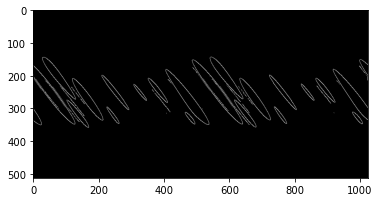

In [209]:
data = load_bigendian(data_dir + "fort.114.0")
#cv2で扱える0-255の整数に整形
data = ((data - min(data.flat))*254/max(data.flat))
data = data.astype("uint8")
print(data)
edges = cv2.Canny(data, threshold1=150, threshold2=200)
plt.imshow(cv2.cvtColor(edges, cv2.COLOR_GRAY2RGB))
cv2.imwrite('edges.jpg', edges)

# 流線

参考 https://python-pyramid.com/?p=143

result   Y,X: 255 511
original Y,X: (513, 1025)
result   Y,X: 255 511
original Y,X: (513, 1025)


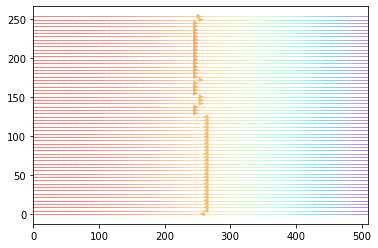

In [10]:
dataX = load_bigendian(data_dir + "fort.116.0")
dataY = load_bigendian(data_dir + "fort.117.0")

carnel1 = ave_carnel(4)
#carnel1 = np.array([[0,0,0,0],[0,1/12,1/6,1/4],[0,1/12,1/6,1/4],[0,0,0,0]])
carnel2 = carnel1.T
dataX = convolute(dataX, carnel2,stride=2)
dataY = convolute(dataY, carnel1,stride=2)

x = range(dataX.shape[1])
y = range(dataY.shape[0])
#X,Y方向それぞれのベクトルに対して座標の行列を設定
X, Y = np.meshgrid(x, y)
#X,Y方向それぞれのベクトルの強さ
u = dataX
v = dataY

# print(X.shape)
# print(Y.shape)
# print(u.shape)
# print(v.shape)
U = -1 - X**2 + Y#color
speed = np.sqrt(u**2 + v**2)
lw = 7*speed / speed.max()

plt.figure(1)
#sns.heatmap(dataY)
plt.streamplot(X, Y, u, v, density=[1.5,2], color=U, arrowstyle='-|>', linewidth=0.5,cmap="rainbow")
# plt.savefig("v_stream3.png")
plt.show()


# 流線の表示 ごり押し
畳み込み後のX,Y方向それぞれのスカラーを一つのベクトルに組み合わせる。その後ベクトルの向きと距離を計算して矢印を生成。
畳み込み後のピクセル数がそのまま矢印の数になる。元のplotと合成する際には座標のすり合わせが必要

In [258]:
def vec2unit(vec):
    x2 = vec[0]**2
    y2 = vec[1]**2
    r2 = x2 + y2
    resx = np.sqrt(x2/r2)
    resy = np.sqrt(y2/r2)
    return (resx,resy,np.sqrt(r2))
def vec2norm(vec):
    return np.sqrt(vec[0]**2 + vec[1]**2)
def make_arrow(unit, norm, size=(10,10)):

#def make_zahyouziku

# エネルギー

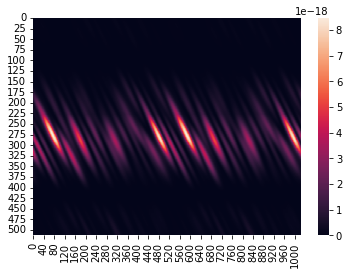

In [51]:
# 速さと密度について
dens = load_bigendian(data_dir + "fort.111.0")
vX = load_bigendian(data_dir + "fort.113.0")
vY = load_bigendian(data_dir + "fort.114.0")
energy = dens * (vX**2 + vY**2) / 2
show(energy, "d_vx2+vy^2")

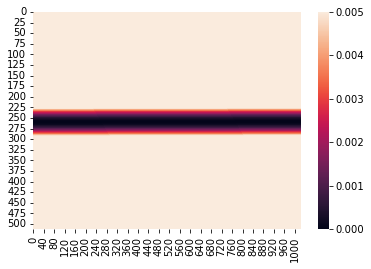

In [50]:
# 磁場について
bY = load_bigendian(data_dir + "fort.117.0")
bX = load_bigendian(data_dir + "fort.116.0")
bhoge = (bX**2 + bY**2)/2
show(bhoge)

# ローテーション

In [4]:
#関数の微分でローテーション
import sympy as sp
sp.var(' x y z ')#いる？
from sympy.core.function import Function


v1 = Function('v1')(x,y,z)
v2 = Function('v2')(x,y,z)
v3 = Function('v3')(x,y,z)
V = sp.Matrix([[v1],[v2],[v3]])
def rot(V):
    return sp.Matrix([
        [sp.diff(V[2,0],y)-sp.diff(V[1,0],z)],
        [sp.diff(V[0,0],z)-sp.diff(V[2,0],x)],
        [sp.diff(V[1,0],x)-sp.diff(V[0,0],y)]])
rot(V)

Matrix([
[-Derivative(v2(x, y, z), z) + Derivative(v3(x, y, z), y)],
[ Derivative(v1(x, y, z), z) - Derivative(v3(x, y, z), x)],
[-Derivative(v1(x, y, z), y) + Derivative(v2(x, y, z), x)]])

In [42]:
#離散データの微分
def diff(x, h):
    """
    精度低めの普通の微分。誤差:h**2
    """
    res = x[2:] - x[:-2]
    print(x[1:])
    print(x[:-1])
    return res/(2*h)
def diff4(x, h):
    """
    精度高めの微分・。誤差:h**4
    1回微分{-f(x+2h)+8f(x+h)-8f(x-h)+f(x-2h)}/12h
    xは時系列データ,hはデータ間の時間(second)
    ベクトル長が4短くなる
    """
    res = -x[4:] + 8*x[3:-1] - 8*x[1:-3] + x[:-4]
    return res/(12*h)


def diff4_x(data: np.ndarray, h:float):
    res = np.ndarray([])
    for vecx in data:
        if res.shape == tuple():
            res = diff4(vecx, h)
        else:
            res = np.append(res,diff4(vecx, h))
    return res.reshape(data.shape[0],data.shape[1]-4)
def diff4_y(data: np.ndarray, h:float):
    data = data.T
    res = np.ndarray([])
    for vecy in data:
        if res.shape == tuple():
            res = diff4(vecy, h)
        else:
            res = np.append(res,diff4(vecy, h))
    return res.reshape(data.shape[0],data.shape[1]-4).T
def rot2d(vX:np.ndarray,vY:np.ndarray):
    """
    vX,vYよりローテーションを出す。結果はz方向のベクトル
    y方向については、vZ(zx平面)、vX(zx平面)の順で入力、x方向はvY(yz平面)、vZ(yz平面)の順で入力すると得られる。
    x､y､zそれぞれの出力であるスカラーの行列に対して、
    それぞれの方向の単位ベクトルを掛けて足せば3次元のローテーションが求まる
    """
    return diff4_x(vY,1)[2:-2,] - diff4_y(vX,1)[:,2:-2]

"""
rot2dの結果に対して単位ベクトルを掛けるやり方。
a = np.array([[0,1,2,3],[0,4,5,6],[0,7,8,9]])
e = np.array([1,0,0])
mylist = [[j *e for j in i ] for i in a]
"""
  


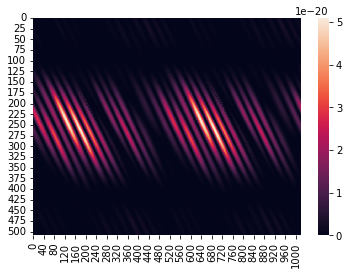

In [49]:
vX = load_bigendian(data_dir + "fort.113.0")
vY = load_bigendian(data_dir + "fort.114.0")
vZ = load_bigendian(data_dir + "fort.115.0")
show((rot2d(vX,vY)**2)/2)
# diff4_y(vX,1)

In [6]:
res = np.ndarray([])
res = np.append(res,np.array([1,2,3]))
res

array([0., 1., 2., 3.])

In [93]:
a = np.array([[0,1,2,3],[0,4,5,6],[0,7,8,9]])
e = np.array([1,0,0])
mylist = [[j *e for j in i ] for i in a]

In [96]:
print(np.array(mylist))

[[[0 0 0]
  [1 0 0]
  [2 0 0]
  [3 0 0]]

 [[0 0 0]
  [4 0 0]
  [5 0 0]
  [6 0 0]]

 [[0 0 0]
  [7 0 0]
  [8 0 0]
  [9 0 0]]]
